<a href="https://colab.research.google.com/github/yeric1789/CMSC320_Final_Project/blob/main/NoteBookFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.utils import resample
from scipy.stats import mannwhitneyu,shapiro

In [3]:
sns.set_style("darkgrid")

#Loading the data/Data collection

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv('/content/drive/MyDrive/CMSC320-Intro_data_science/FinalProject/Data/Data_Entry_2017.csv')
data = data.iloc[:4999] # We use a subset 
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


#Data exploration 
Each observation has an image and some more attributes attached to it, we will start by exploring some of the attributes first. 

In [6]:
data.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,0.0
mean,7.153431,664.016003,51.809362,2585.575115,2465.156431,0.157476,0.157476,NaN
std,11.211108,395.466319,17.015137,332.878470,392.205703,0.015117,0.015117,NaN
min,0.000000,1.000000,9.000000,1694.000000,1677.000000,0.115000,0.115000,NaN
25%,0.000000,318.000000,40.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,643.000000,54.000000,2500.000000,2500.000000,0.168000,0.168000,NaN
75%,8.000000,1021.500000,64.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,66.000000,1335.000000,94.000000,3056.000000,3056.000000,0.198800,0.198800,NaN


In [7]:
def count_disease(findings):
  for j in findings:
    if j in overview.keys():
      overview[j] += 1
    else: 
      overview[j] = 1

In [8]:
data['Finding Labels'] = data.apply(lambda x: x['Finding Labels'].split('|'),axis = 1)

# Count the different 
overview = {}
for findings in data['Finding Labels']:
  for j in findings:
    if j in overview.keys():
      overview[j] += 1
    else: 
      overview[j] = 1

In [9]:
overview

{'Cardiomegaly': 196,
 'Emphysema': 125,
 'Effusion': 487,
 'No Finding': 2754,
 'Hernia': 27,
 'Infiltration': 830,
 'Mass': 161,
 'Nodule': 214,
 'Atelectasis': 460,
 'Pneumothorax': 199,
 'Pleural_Thickening': 165,
 'Pneumonia': 65,
 'Fibrosis': 172,
 'Edema': 90,
 'Consolidation': 205}

Now we can create a one-hot encoding dataframe of all the labels being assigned to each image. After that it can be concatenated with the originial data matrix. 

In [10]:
dummies = pd.DataFrame(np.zeros((len(data), len(overview.keys())), dtype=np.int), columns=overview.keys())
for i,des in enumerate(data['Finding Labels']):
  dummies.loc[i][des] = 1

#Concat horizontally
data = pd.concat([data,dummies],axis=1)

<ipython-input-10-9b6e35be31a7>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dummies = pd.DataFrame(np.zeros((len(data), len(overview.keys())), dtype=np.int), columns=overview.keys())


Now let's see which diseases are the most common, by plotting a histogram. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

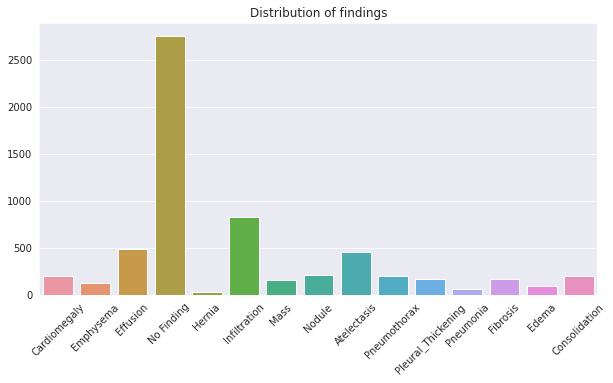

In [11]:
plt.rcParams["figure.figsize"] = (10,5)
x = list(overview.keys())
y = list(overview.values())
sns.barplot(x,y)
plt.title('Distribution of findings')
plt.xticks(rotation=45)

As can be seen there is a big class imbalance, so what we are going to do, is to resample everything that is not No finding. We will be using sklearns resampler in order to upsample the finding classes.

We are however dealing with two different types of classification binary and multi-label, for the binary case we don't really need to upsample the data. 

In [12]:
df_majority = data[data['No Finding']==1]
df_minority = data[data['No Finding']==0]

print(f'#No finding:{len(df_majority)} \n#Findings:{len(df_minority)}')
#Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority))
#data = pd.concat([df_minority_upsampled,data])

#No finding:2754 
#Findings:2245


Lets explore how the age distribution is, by plotting the histogram of the Patient age. 

Text(0.5, 1.0, 'Patient age')

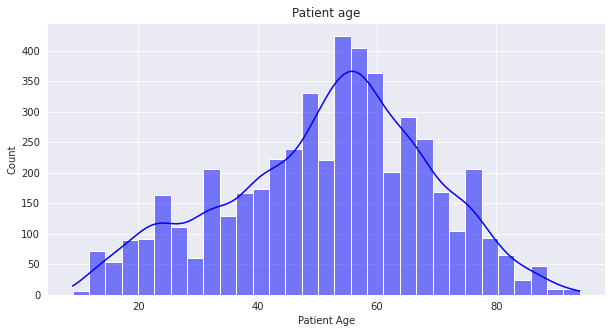

In [13]:
sns.histplot(data = data,x = 'Patient Age',color = 'b',kde=True)
plt.title("Patient age")

However for the sake of investigating if we may have any bias problems, lets differentiate between genders. This could show to be important since we want to know if the model might have some sort of bias against age or gender. 

Text(0.5, 1.0, 'Patient age')

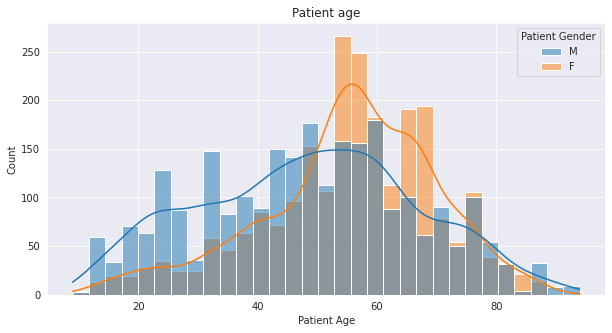

In [14]:
sns.histplot(data = data,x = 'Patient Age', hue = 'Patient Gender',kde=True)
plt.title("Patient age")

## Testing for normality and difference in distributions
Another thing our data accounts for is gender, so we can also vizualize if a Gender would have influence on how frequent a lung disese occurs. One thing we can interpret from the plots is that it looks like the Male group has a higher variance. However from the plot it is quite hard to tell.

Another thing is that it looks like the female might follow a normal distribution somewhat however for the male we are hesitant to make any conclusions. In order to decide we will perform The Shapiro-Wilk test which has H0: that the data was drawn from a normal distribution, the result of this test will then determine if we choose to use a parametric or none paramtric test between the two groups. 



In [15]:
gender_df = data.groupby('Patient Gender')
female, male = data[data['Patient Gender'] == 'F']['Patient Age'], data[data['Patient Gender'] == 'M']['Patient Age']
gender_df['Patient Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Patient Gender,,,,,,,,
F,2391.0,55.293183,14.796351,9.0,48.0,56.0,66.0,92.0
M,2608.0,48.615414,18.248206,10.0,34.0,49.0,61.0,94.0


In [16]:
shapiro(female).pvalue

1.0693677867986169e-19

In [17]:
# The Shapiro-Wilk test
female_pval = shapiro(female).pvalue 
male_pval = shapiro(male).pvalue
string = f'p-value in test for normality \nFemale: {female_pval} \nMale: {male_pval}' 
print(string)

p-value in test for normality 
Female: 1.0693677867986169e-19 
Male: 5.409367124018091e-15


So from these results it is safe to say that we can not assume normality. Because of this we will be using the The Mann-Whitney U test which is a non parametric test between distributions. The non-parametric is important here since it does not take any distribution into account, the reason we will not always be using this is because it has lower statistical power, which means it will more often reject the h0 when it should not. 

In [18]:
# mannwhitneyu test
diff_pvalue = mannwhitneyu(male,female).pvalue
print(f'We reject the H0 with significance 0.05 and with p-value: {diff_pvalue}')

We reject the H0 with significance 0.05 and with p-value: 3.0050529165554154e-45


So from all of this we can derive that there is a significant difference between the age of Male and Females in the data-set. Do note that all of this has been computed on a subset of the real data-set and thus may not be representative for the entire data-set. 

## Correlation between variables

Now we can plot the correlation matrix, to check if any of the findings often occur togehter. Note that we have dropped *'No Finding'* since it will never occur together with any of the other variables. 

Text(0.5, 1.0, 'Correlation matrix of findings')

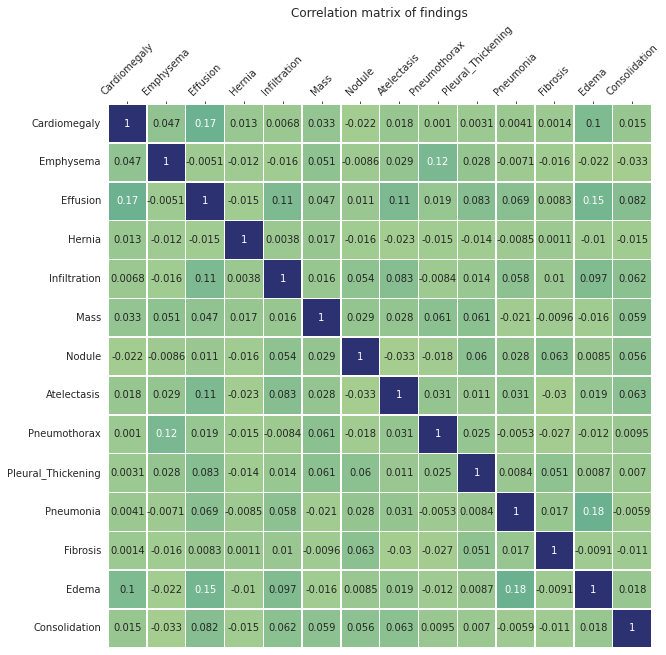

In [19]:
plt.rcParams["figure.figsize"] = (15,10)
df = dummies.drop(columns = 'No Finding').corr()
ax = sns.heatmap(df,annot = True,cmap="crest",square=True, linewidths=.5,cbar=False)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=45)
plt.title('Correlation matrix of findings')

# Predicting the label from images. 

In [20]:
import torch 
from torchvision import datasets, transforms
from torchvision.models import inception_v3,resnext50_32x4d
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
from skimage import io, transform
from sklearn.model_selection import train_test_split
from torch import nn
import torch.functional as F
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


First let us make sure that we make a trainning set and a testing set


In [22]:
train_df, test_df = train_test_split(data,test_size=0.15, random_state=42)

## Data handleing with pytorch

In order to work with pytorch and the image data, we have to create a costoum data-set. This is basically just a class, where you specify the __len__() and __getitem__() methods. Especially __getitem__() is important in this case, since we don't wan't to load all of the images into the ram at once. We are working with a big data-set and we can easily end up using all of the ram if we are not smart about how we do the loading of the data. 

The way we construct the data-set class is that each time the __getitem__() class is called it loads the image from the directory. This means that we only take images into the ram when we actually need them. 

Another thing we adress in this class is the construction of labels and transformations we apply to the images. We will be explaining two forms of classificatin binary and multi-label. The first method is quite a lot simpler than the second. 

###Binary
The way we can convert the problem to a binary problem is simply by only predicting if the image contains a finding or no finding, but not which specific finding that is being considered. 

### Multi-label 
Here we would actually try to predict which exact label to assign to given image.

The way this can be handled with pytorch is simply to create a binary variable indicating if we want to work with the binary data or the multi-label data. Notice how there is different if statements in the __getitem__() method. This allows us to only implement one class, instead of having to redefine the class. 

In [23]:
class LungDataSet(Dataset):
  
  def __init__(self,df,root_dir,input_size,tform = None,binary = True):
    self.df = df 
    self.root_dir = root_dir
    self.tform = tform
    self.input_size = input_size
    self.binary = binary

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = self.df.iloc[idx,0]
    path = os.path.join(self.root_dir,img_name)
    #print(path)

    image = io.imread(path)

    if len(image.shape)>2: # For some reason some of the images have copied slices of them self so they are 3d 
      image = image[:,:,0]
    
    tf = transforms.Resize(image.size)
    #image = torch.tensor([image for i in range(3)])
    image = tf(torch.tensor([image for i in range(3)])) # This is just me trying stuff 
    
    if image.shape == torch.Size([3, 299, 299, 4]):
      print(path)
    
    if self.binary:
      labels = self.df.iloc[idx,15] #12: if we use all labels
      labels = torch.tensor([1,0]) if labels.item() == 0 else torch.tensor([0,1]) # Notice how 0 in no finding means there is a finding
    else: 
      labels = self.df.iloc[idx,12:]
      labels = labels.to_list()
    
    labels = torch.tensor(labels).to(float)
    #print()
    if self.tform:
      image = self.tform(image)

    sample = {'image': image, 'labels': labels}


    return sample 

### Transforms of images 
As we are using the ResNet architecture, we are risking overfitting the network to the images, in order to combat this we will be using transformations. The ones we will be using are random horizontal flips and random vertical flips. These transformations are basically just flipping the images in random directions, this is in the hope that the network will learn the representation of the actual illness and not be biased towards the direction of the image it is seeing. Furthermore 

In [24]:
tform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

dir = '/content/drive/MyDrive/CMSC320-Intro_data_science/FinalProject/Data/images/'
train_set = LungDataSet(df = train_df,root_dir = dir,input_size = (299,299),binary = True, tform = tform)
test_set = LungDataSet(df = test_df,root_dir = dir,input_size = (299,299),tform = tform)

In [25]:
#train_set[0]['image'].shape

## Visualize the data we will be training on 

In [ ]:
fig = plt.figure()

for i in range(len(train_set)):
    sample = train_set[i]

    print(i, sample['image'].shape, sample['labels'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'][0,:,:])

    if i == 3:
        plt.show()
        break

In [ ]:
#Train Loader 
train_dataloader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)

#Test Loader
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)

We will be using Resnet as the backbone for our image classifier, what this means is that we are using the pretrained weights for the architecture Resnet, and then we modify the last layer to be a linear classifier which will then output the desired number of output neurons we want. 

In the implementation below notice, how we again make sure that we can take a different number of classes, this is again in order to do both binary classification and multi-label classification. 

In [ ]:
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.n_classes = n_classes
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax()
             
    def forward(self, x):
        if self.n_classes > 2:
          return self.sigm(self.base_model(x))
        else: 
          return self.softmax(self.base_model(x))

Define the actual objects. 

In [ ]:
model_res = Resnext50(n_classes =  2)
model_res = model_res.to(device)

### Loss, optimizer and scheduler 
Define loss function and the optimizer, we will be using the Adam optimizer. The loss function will be binary cross-entropy. Another thing we will define is a scheduler, which allows us to addapt the learning rate of the optimizer for each epoch. We do this because we may be interested in having a higher lr in the beginning of the training, and then as we progress we want to take smaller and smaller steps in order to reduce the chance of overshooting the minima

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-6)
scheduler = StepLR(optimizer, step_size=1, gamma=0.2)

## Model training
Training loop for the model. In this cell we will be training the model. This is doen by first calling `model.train()` which basically sets the model in training mode. After this is done, we want to make a prediction for each of the batches *(we are using stochastic gradient descent)* and then based of that predictin find the gradient so that we can optimize our network. The way we find the gradient is by calling `loss.backward()` this runs the back probagation algorithm. 

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_tracker = []
    for batch, point in tqdm(enumerate(dataloader)):
        X = point['image']
        y = point['labels']

        X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_tracker.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return loss_tracker

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    predictions = []
    #f = nn.Softmax(dim = 1)
    with torch.no_grad():
        for point in dataloader:
            X = point['image'].to(torch.float32)
            y = point['labels'].to(torch.float32)

            X, y = X.to(device,dtype=torch.float), y.to(device,dtype=torch.float)
            pred = model(X)
            predictions.append((pred,y))
            #return pred, y 

            test_loss += loss_fn(pred, y).item()
            print(f'loss:{test_loss} \n Prediction:{pred}')
            correct += ((pred > 0.5 - y).sum().item()) == 0
            
    test_loss /= num_batches
    correct /= size
    print(correct)
    return test_loss,predictions

##Binary classification 
Now that we have the two functions defined we are ready to actually do the training, by calling the functions in another loop. Each iteration of a training loop, is known as an epoch. For each epoch we train we also want to validate if our model is overfitting or not, therefore we call the test function (we should prob rename). 

Notice that we in this loop also calls the `scheduler.step()` which tells the scheduler that it should decrease the learning rate by the ammount specified earlier as the gamma value. Further more we also incorporate an early stopping, meaning that if the current version of the model does not have improved test accuracy over the last two epochs we break it. The reason for this is that an increasing test performance is signaling that our model may be overfitting to the training data. 

In [ ]:
epochs = 15
train_loss = []
test_loss = []
predictions = []
for t in tqdm(range(epochs)):
  # Train
  epoch_train_loss = train(train_dataloader, model_res, loss_fn, optimizer)
  train_loss.append(epoch_train_loss)

  #Test
  epoch_test_loss, epoch_predictions = test(test_dataloader, model_res, loss_fn)
  test_loss.append(epoch_test_loss)
  predictions.append(epoch_predictions)

  # Decrease lr for each epoch.
  scheduler.step()
  
  #Impose early stopping 
  if t > 2 and test_loss[-1] > test_loss[-2] and test_loss[-1] > test_loss[-3]:
    break 

The step above is where you as the programmer are going to do so adjustments yourself. The overall thing to look for, is a generel decreasing training loss, but also that the test loss is decreasing along with it. If you start to see a test loss that is increasing while training loss is decreasing then abort mission, because you are overfitting. 

Another thing thing when training an NN, is that we have to set the hyper-parameters our self. One could use gridsearch or baysian optimization to find these paramters however these will require you to fully train a network multiple times, and in our case when we are using ResNet as the backbone it has around 11 million parameters. Therefore if you see the training loss bouncing around but not really decreasing in generel try to lower the learning rate. Youd could also try to adjust the batch size, since we are using stochastic gradient descent. The batchsize can be thought of as the amount of samples we use to estimate our gradient before stepping in the negative direction of it. 

In [ ]:
# Save the model paramters as tar file to you working directory 
torch.save(model_res.state_dict(), './Resnet50.pth')